<a href="https://colab.research.google.com/github/anton-brandl/sam-bridges/blob/main/notebooks/20230610_finetuning_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install segment_anything segment_geospatial opencv-python pycocotools matplotlib onnxruntime onnx


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 84.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 60.8 MB/s eta 0:00:00


## Step 1: Data Preparation

### Load Sample Training data from Disk

### Format data using SAM preprocess functions
* use utils.transform.ResizeLongestSide to resize the image
* convert the image to a pytorch tensor
* use SAM preprocess functions

## Step 2: Getting SAM module instance and prepare it for **finetuning**

## Step 3: Starting Finetuning using torch or lightning



## Step 4: Evaluation


Most of the following code is from encord.com:

In [3]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
from samgeo import download_checkpoint

#model_type = 'vit_h'
#checkpoint = 'sam_vit_h_4b8939.pth'
#checkpoint_url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
checkpoint_url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth'
device = 'cuda:0'
# device = 'cpu:0'

# credits: Cached downloading of checkpoint was taken from samgeo project

# Download the checkpoint if it does not exist
CACHE_PATH = os.environ.get(
    "TORCH_HOME", os.path.expanduser("~/.cache/torch/hub/checkpoints")
)

if not os.path.exists(checkpoint):
    basename = os.path.basename(checkpoint)
    checkpoint = os.path.join(CACHE_PATH, basename)
    if not os.path.exists(checkpoint):
        print(f"Checkpoint {checkpoint} does not exist.")
        download_checkpoint(url=checkpoint_url, output=checkpoint)

Checkpoint /root/.cache/torch/hub/checkpoints/sam_vit_b_01ec64.pth does not exist.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
To: /root/.cache/torch/hub/checkpoints/sam_vit_b_01ec64.pth
100%|██████████| 375M/375M [00:01<00:00, 210MB/s]


In [4]:
!ls -al ~/.cache/torch/hub/checkpoints/*

-rw-r--r-- 1 root root 375042383 Jun 13 14:19 /root/.cache/torch/hub/checkpoints/sam_vit_b_01ec64.pth


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


We convert the input images into a format SAM's internal functions expect.

In [6]:
# Preprocess the images
from collections import defaultdict

import torch

from segment_anything.utils.transforms import ResizeLongestSide
import cv2
import random
from typing import List, Dict
import numpy as np

transform = ResizeLongestSide(sam_model.image_encoder.img_size)

def preprocess_input_image(image_rgb):
  input_image = transform.apply_image(image_rgb)
  input_image_torch = torch.as_tensor(input_image, device=device)
  transformed_image = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]

  input_image = sam_model.preprocess(transformed_image)
  original_image_size = image_rgb.shape[:2]
  input_size = tuple(transformed_image.shape[-2:])

  return input_image, input_size, original_image_size



In [7]:
# from segment_anything.utils.amg import box_xyxy_to_xywh
from pathlib import Path
import numpy as np
from typing import List, Dict
from tqdm import tqdm
from skimage.io import imread

dataset_folder = Path('drive/MyDrive/sam-bridges/dataset')

def box_xywh2xyxy(box: np.ndarray) -> np.ndarray:
  """Expects a numpy array shape Bx4"""

  if len(box)==0:
    return box

  box = box.copy()
  box[..., 2] += box[..., 0]  # Width to x2
  box[..., 3] += box[..., 1]  # Height to y2
  return box

def load_dataset(dataset_path: Path) -> List[Dict] :
  dataset = []
  for datapoint_pth in tqdm(dataset_path.glob('*')):
    sat = imread(datapoint_pth / 'sat.png')

    box_xywh = np.load(datapoint_pth / 'bboxes.npy')  # loaded in xywh format
    box_xyxy = box_xywh2xyxy(box_xywh)
    dataset.append({
        'tile_id': datapoint_pth.name,
        'bboxes': box_xyxy,
        'bg_points': np.load(datapoint_pth / 'bg_points.npy'),
        'fg_points': np.load(datapoint_pth / 'fg_points.npy'),
        'mask': imread(datapoint_pth / 'mask.png')//255,
        'sat': sat,
    })
  return dataset

train_dataset = load_dataset(dataset_folder / "train")
test_dataset = load_dataset(dataset_folder / "test")

192it [04:26,  1.39s/it]
48it [01:04,  1.35s/it]


In [8]:
# Set up the optimizer, hyperparameter tuning will improve performance here
lr = 1e-3
wd = 0
optimizer = torch.optim.Adam(sam_model.mask_decoder.parameters(), lr=lr, weight_decay=wd)

loss_fn = torch.nn.MSELoss()
# loss_fn = torch.nn.BCELoss()
#keys = list(bbox_coords.keys())

## Run fine tuning

This is the main training loop. 

Improvements to be made include batching and moving the computation of the image and prompt embeddings outside the loop since we are not tuning these parts of the model, this will speed up training as we should not recompute the embeddings during each epoch. Sometimes the optimizer gets lost in the parameter space and the loss function blows up. Restarting from scratch (including running all cells below 'Prepare Fine Tuning' in order to start with default weights again) will solve this.

In a production implementation a better choice of optimiser/loss function will certainly help.

In [9]:
# Preprocess image embeddings

def preprocess_image_embeddings(dataset):
  for datapoint in tqdm(dataset):
    input_image, input_size, original_image_size = preprocess_input_image(datapoint['sat'])
    datapoint['input_size'] = input_size
    datapoint['original_image_size'] = original_image_size

    input_image = input_image.to(device)
    with torch.no_grad():
      datapoint['image_embedding'] = sam_model.image_encoder(input_image)

preprocess_image_embeddings(train_dataset)
preprocess_image_embeddings(test_dataset)

100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


In [10]:
from statistics import mean

from tqdm import tqdm, trange
from torch.nn.functional import threshold, normalize
import random

random.seed(57)

num_epochs = 40
losses = []
val_losses = []

def select_single_box(prompt_boxes, mask, mode='random'):
  gt_mask_new = mask
  if len(prompt_boxes)==0:
    selected_box = None
  else:
    if len(prompt_boxes) ==1:
      selected_box = prompt_boxes
    else:
      # Currently, segment-anything only accepts a single input box
      if mode=='random':
        selected_box = prompt_boxes[random.randint(0, len(prompt_boxes)-1)]
      elif mode=='first':
        selected_box = prompt_boxes[0]
      else:
        raise RuntimeError(f'Unknown mode: {mode}')

      gt_mask_new = np.zeros(mask.shape)
      x1,y1,x2,y2 = selected_box
      gt_mask_new[y1:y2,x1:x2] = mask[y1:y2,x1:x2]

  return selected_box, gt_mask_new


def validation(sam_model, test_dataset, loss_fn):
  predictor = SamPredictor(sam_model)
  losses = []
  for test_dp in test_dataset:
    predictor.original_size = test_dp['original_image_size']
    predictor.input_size = test_dp['input_size']
    predictor.features = test_dp['image_embedding']
    predictor.is_image_set = True

    selected_box, gt_mask = select_single_box(test_dp['bboxes'], test_dp['mask'], mode='first')

    mask_pred, _, _ = predictor.predict(
      point_coords=None,
      box=selected_box,
      multimask_output=False,
    )
    
    mask_pred_tensor = torch.as_tensor(mask_pred[0,:,:], dtype=torch.float32)
    gt_mask_tensor = torch.as_tensor(gt_mask > 0, dtype=torch.float32)

    losses.append(loss_fn(mask_pred_tensor, gt_mask_tensor).item())

  return losses


for epoch in trange(num_epochs):
  random.shuffle(train_dataset)
  epoch_losses = []
  for train_dp in train_dataset:
    input_size = train_dp['input_size']
    original_image_size = train_dp['original_image_size']
    
    # No grad here as we don't want to optimise the encoders
    with torch.no_grad():
      if "image_embedding" not in train_dp:
        input_image = train_dp['input_image'].to(device)
        image_embedding = sam_model.image_encoder(input_image)
        train_dp['image_embedding'] = image_embedding
      
      selected_box, gt_mask = select_single_box(train_dp['bboxes'], train_dp['mask'])
      prompt_boxes = train_dp['bboxes']

      if selected_box is not None:
        boxes = transform.apply_boxes(selected_box, original_image_size)
        boxes_torch = torch.as_tensor(boxes, dtype=torch.float, device=device)
        boxes_torch = boxes_torch[None, :]
      else:
        boxes_torch = None

      # TODO: Add points as input
      sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
          points=None,
          boxes=boxes_torch,
          masks=None,
      )

    low_res_masks, iou_predictions = sam_model.mask_decoder(
      image_embeddings=train_dp['image_embedding'],
      image_pe=sam_model.prompt_encoder.get_dense_pe(),
      sparse_prompt_embeddings=sparse_embeddings,
      dense_prompt_embeddings=dense_embeddings,
      multimask_output=False,
    )

    upscaled_masks = sam_model.postprocess_masks(low_res_masks, input_size, original_image_size).to(device)
    binary_mask = normalize(threshold(upscaled_masks, 0.0, 0))

    gt_mask_resized = torch.from_numpy(np.resize(gt_mask, (1, 1, gt_mask.shape[0], gt_mask.shape[1]))).to(device)
    gt_binary_mask = torch.as_tensor(gt_mask_resized > 0, dtype=torch.float32)
    
    loss = loss_fn(binary_mask, gt_binary_mask)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_losses.append(loss.item())
  losses.append(epoch_losses)
  epoch_val_losses = validation(sam_model, test_dataset, loss_fn)
  val_losses.append(epoch_val_losses)
  print(f'EPOCH: {epoch}')
  print(f'Mean loss: {mean(epoch_losses)}')
  print(f'Val loss: {mean(epoch_val_losses)}')


  2%|▎         | 1/40 [00:05<03:35,  5.54s/it]

EPOCH: 0
Mean loss: 0.013047112384811044
Val loss: 0.0002585517019421483


  5%|▌         | 2/40 [00:14<04:57,  7.84s/it]

EPOCH: 1
Mean loss: 0.002364555994669596
Val loss: 0.00020237910939613357


  8%|▊         | 3/40 [00:20<04:12,  6.83s/it]

EPOCH: 2
Mean loss: 0.0024539894657209516
Val loss: 0.00016288992749953954


 10%|█         | 4/40 [00:25<03:43,  6.22s/it]

EPOCH: 3
Mean loss: 0.0019034544626871746
Val loss: 0.00017341566732890593


 12%|█▎        | 5/40 [00:32<03:41,  6.34s/it]

EPOCH: 4
Mean loss: 0.0021436214447021484
Val loss: 0.000128251536807511


 15%|█▌        | 6/40 [00:37<03:20,  5.90s/it]

EPOCH: 5
Mean loss: 0.0019815762837727866
Val loss: 0.00012862829559405023


 18%|█▊        | 7/40 [00:46<03:50,  6.98s/it]

EPOCH: 6
Mean loss: 0.001916805903116862
Val loss: 0.00012862829559405023


 20%|██        | 8/40 [00:50<03:13,  6.04s/it]

EPOCH: 7
Mean loss: 0.0020488103230794272
Val loss: 0.00012862829559405023


 22%|██▎       | 9/40 [00:54<02:44,  5.32s/it]

EPOCH: 8
Mean loss: 0.002009789148966471
Val loss: 0.00012862829559405023


 25%|██▌       | 10/40 [01:01<02:56,  5.88s/it]

EPOCH: 9
Mean loss: 0.0020636717478434243
Val loss: 0.00012862829559405023


 28%|██▊       | 11/40 [01:05<02:35,  5.36s/it]

EPOCH: 10
Mean loss: 0.0019364356994628906
Val loss: 0.00012862829559405023


 30%|███       | 12/40 [01:09<02:16,  4.86s/it]

EPOCH: 11
Mean loss: 0.0019113222757975261
Val loss: 0.00012862829559405023


 32%|███▎      | 13/40 [01:13<02:03,  4.59s/it]

EPOCH: 12
Mean loss: 0.0020279884338378906
Val loss: 0.00012862829559405023


 35%|███▌      | 14/40 [01:18<02:01,  4.66s/it]

EPOCH: 13
Mean loss: 0.001964092254638672
Val loss: 0.00012862829559405023


 38%|███▊      | 15/40 [01:22<01:51,  4.46s/it]

EPOCH: 14
Mean loss: 0.0020890235900878906
Val loss: 0.00012862829559405023


 40%|████      | 16/40 [01:25<01:41,  4.23s/it]

EPOCH: 15
Mean loss: 0.0020628770192464194
Val loss: 0.00012862829559405023


 42%|████▎     | 17/40 [01:30<01:42,  4.46s/it]

EPOCH: 16
Mean loss: 0.002050161361694336
Val loss: 0.00012862829559405023


 45%|████▌     | 18/40 [01:34<01:34,  4.28s/it]

EPOCH: 17
Mean loss: 0.002054135004679362
Val loss: 0.00012862829559405023


 48%|████▊     | 19/40 [01:38<01:26,  4.12s/it]

EPOCH: 18
Mean loss: 0.0019362767537434895
Val loss: 0.00012862829559405023


 50%|█████     | 20/40 [01:42<01:22,  4.13s/it]

EPOCH: 19
Mean loss: 0.00211946169535319
Val loss: 0.00012862829559405023


 52%|█████▎    | 21/40 [01:47<01:21,  4.31s/it]

EPOCH: 20
Mean loss: 0.0020837783813476562
Val loss: 0.00012862829559405023


 55%|█████▌    | 22/40 [01:51<01:14,  4.14s/it]

EPOCH: 21
Mean loss: 0.002000013987223307
Val loss: 0.00012862829559405023


 57%|█████▊    | 23/40 [01:54<01:08,  4.02s/it]

EPOCH: 22
Mean loss: 0.0020629564921061196
Val loss: 0.00012862829559405023


 60%|██████    | 24/40 [02:00<01:09,  4.36s/it]

EPOCH: 23
Mean loss: 0.0018815994262695312
Val loss: 0.00012862829559405023


 62%|██████▎   | 25/40 [02:03<01:02,  4.19s/it]

EPOCH: 24
Mean loss: 0.002019961675008138
Val loss: 0.00012862829559405023


 65%|██████▌   | 26/40 [02:07<00:56,  4.04s/it]

EPOCH: 25
Mean loss: 0.0020438035329182944
Val loss: 0.00012862829559405023


 68%|██████▊   | 27/40 [02:11<00:52,  4.07s/it]

EPOCH: 26
Mean loss: 0.0018799304962158203
Val loss: 0.00012862829559405023


 70%|███████   | 28/40 [02:16<00:50,  4.22s/it]

EPOCH: 27
Mean loss: 0.0020203590393066406
Val loss: 0.00012862829559405023


 72%|███████▎  | 29/40 [02:20<00:45,  4.18s/it]

EPOCH: 28
Mean loss: 0.002003351847330729
Val loss: 0.00012862829559405023


 75%|███████▌  | 30/40 [02:24<00:40,  4.03s/it]

EPOCH: 29
Mean loss: 0.001984278361002604
Val loss: 0.00012862829559405023


 78%|███████▊  | 31/40 [02:29<00:39,  4.36s/it]

EPOCH: 30
Mean loss: 0.00226442019144694
Val loss: 0.00012862829559405023


 80%|████████  | 32/40 [02:32<00:33,  4.18s/it]

EPOCH: 31
Mean loss: 0.002033074696858724
Val loss: 0.00012862829559405023


 82%|████████▎ | 33/40 [02:36<00:28,  4.03s/it]

EPOCH: 32
Mean loss: 0.0019737879435221353
Val loss: 0.00012862829559405023


 85%|████████▌ | 34/40 [02:40<00:24,  4.10s/it]

EPOCH: 33
Mean loss: 0.001953601837158203
Val loss: 0.00012862829559405023


 88%|████████▊ | 35/40 [02:45<00:21,  4.22s/it]

EPOCH: 34
Mean loss: 0.0022341410319010415
Val loss: 0.00012862829559405023


 90%|█████████ | 36/40 [02:49<00:16,  4.08s/it]

EPOCH: 35
Mean loss: 0.0019593238830566406
Val loss: 0.00012862829559405023


 92%|█████████▎| 37/40 [02:52<00:11,  3.97s/it]

EPOCH: 36
Mean loss: 0.0019104480743408203
Val loss: 0.00012862829559405023


 95%|█████████▌| 38/40 [02:57<00:08,  4.31s/it]

EPOCH: 37
Mean loss: 0.0019646485646565757
Val loss: 0.00012862829559405023


 98%|█████████▊| 39/40 [03:01<00:04,  4.13s/it]

EPOCH: 38
Mean loss: 0.002024491628011068
Val loss: 0.00012862829559405023


100%|██████████| 40/40 [03:06<00:00,  4.65s/it]

EPOCH: 39
Mean loss: 0.0021837552388509116
Val loss: 0.00012862829559405023


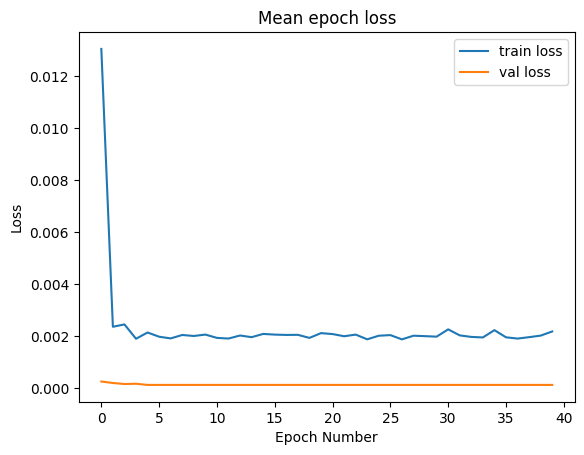

In [11]:
mean_losses = [mean(x) for x in losses]
mean_losses
mean_val_losses = [mean(x) for x in val_losses]

plt.plot(list(range(len(mean_losses))), mean_losses, label='train loss')
plt.plot(list(range(len(mean_losses))), mean_val_losses, label='val loss')
plt.title('Mean epoch loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.legend()

plt.show()

## We can compare our tuned model to the original model

In [12]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device);

In [13]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [14]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
tile_id = 206
test_datapoint = [d for d in test_dataset if d['tile_id']=="206"][0]

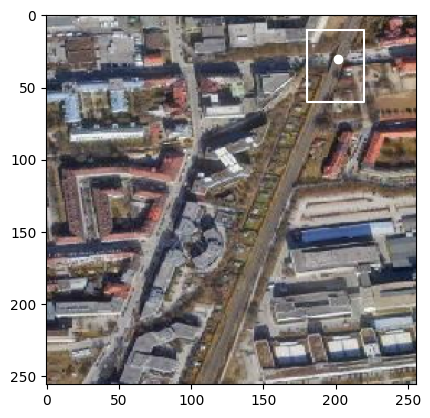

In [15]:
debug_img = test_datapoint['sat']

bbox_x, bbox_y, bbox_w, bbox_h = 180, 10, 40, 50
plt.imshow(test_datapoint['sat'])
plt.plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
input_bbox = box_xywh2xyxy(np.array([bbox_x, bbox_y, bbox_w, bbox_h]))

point_x, point_y = 202, 30
plt.plot(point_x, point_y, color='white', marker = 'o')

In [16]:
# The model has not seen keys[21] (or keys[20]) since we only trained on keys[:20]
tile_id = 206
test_datapoint = [d for d in test_dataset if d['tile_id']=='206'][0]

predictor_tuned.set_image(test_datapoint['sat'])
predictor_original.set_image(test_datapoint['sat'])


We can see here that the tuned model is starting to ignore the whitespace between the words, which is what the ground truths show. With further training, more data and further hyperparameter tuning we will be able to improve this result.

If the image does not render due to size limitations, you can view it here https://drive.google.com/file/d/1ip5aryaxcp8JcEaZubL76oOM6srVzKsc/view?usp=sharing .

In [17]:
test_datapoint['sat'].shape

(256, 256, 3)

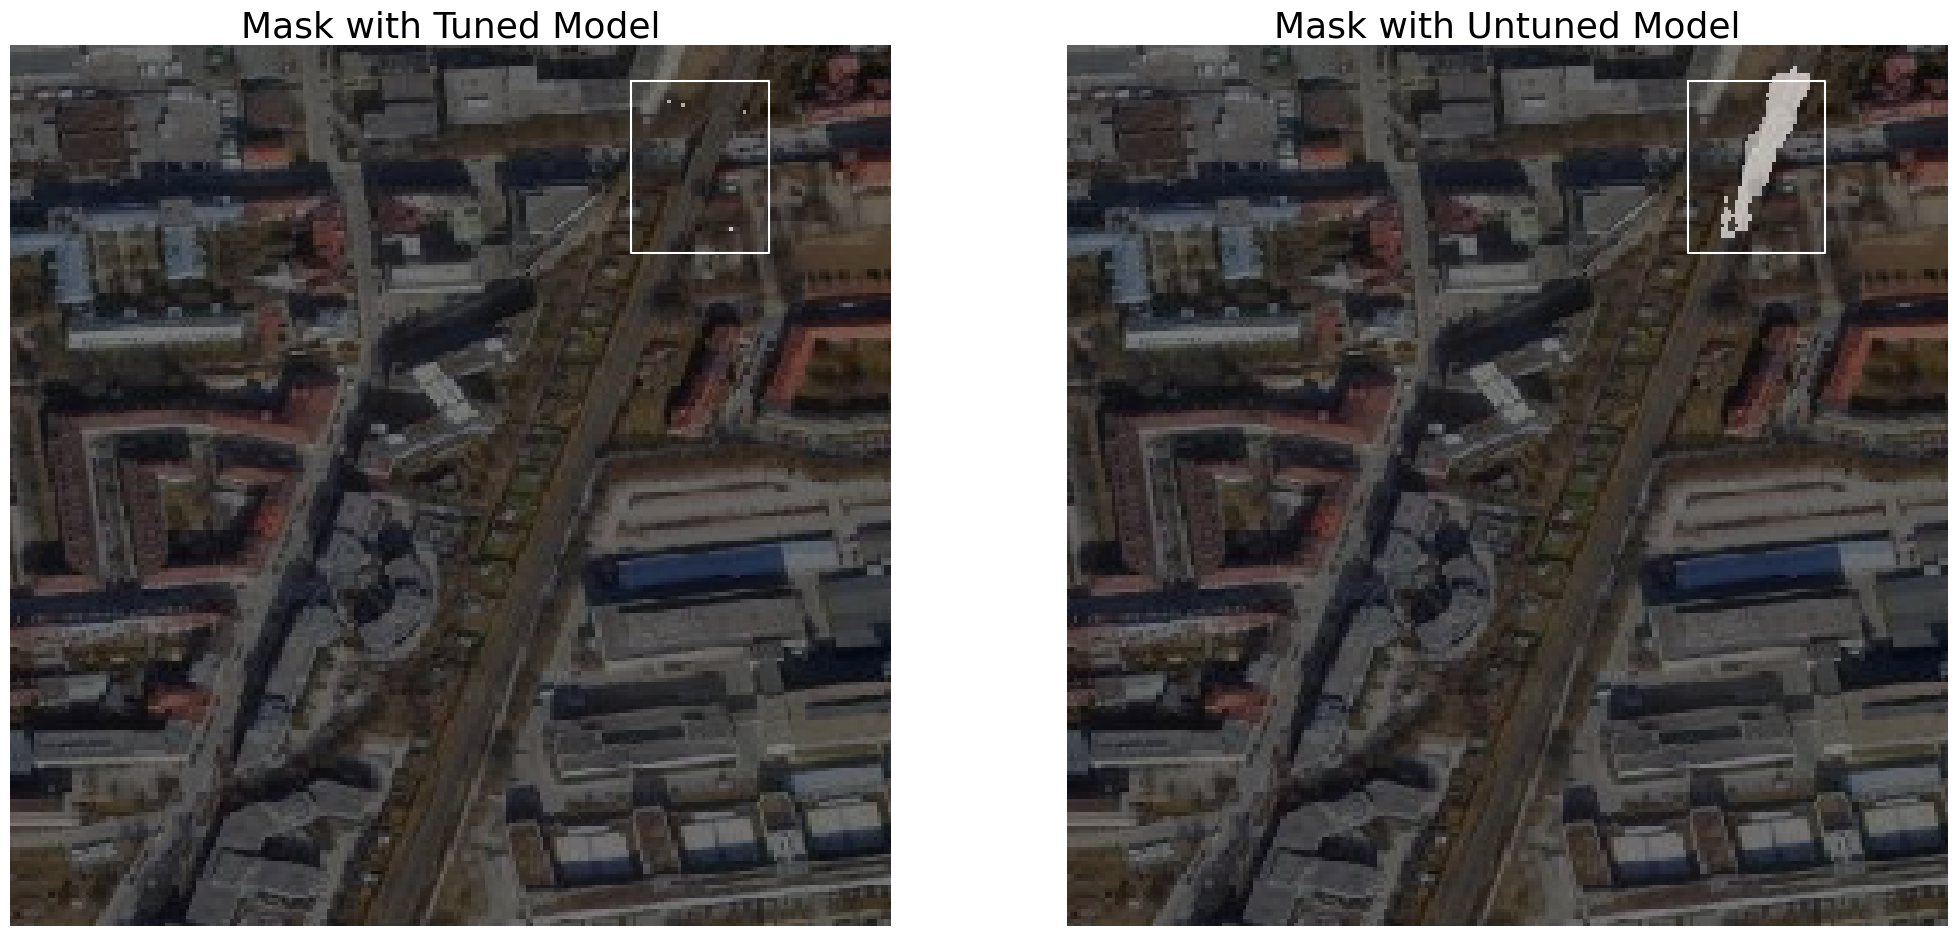

In [18]:
input_bbox = np.array(input_bbox)

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)


%matplotlib inline 
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned.astype(int)[0,...]*255], axis=-1)).astype(int))
axs[0].plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')

axs[1].imshow(((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig.astype(int)[0,...]*255], axis=-1)).astype(int)))
axs[1].plot([bbox_x, bbox_x+bbox_w, bbox_x+bbox_w, bbox_x, bbox_x], [bbox_y, bbox_y, bbox_y+bbox_h, bbox_y+bbox_h, bbox_y], color='white')
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()  

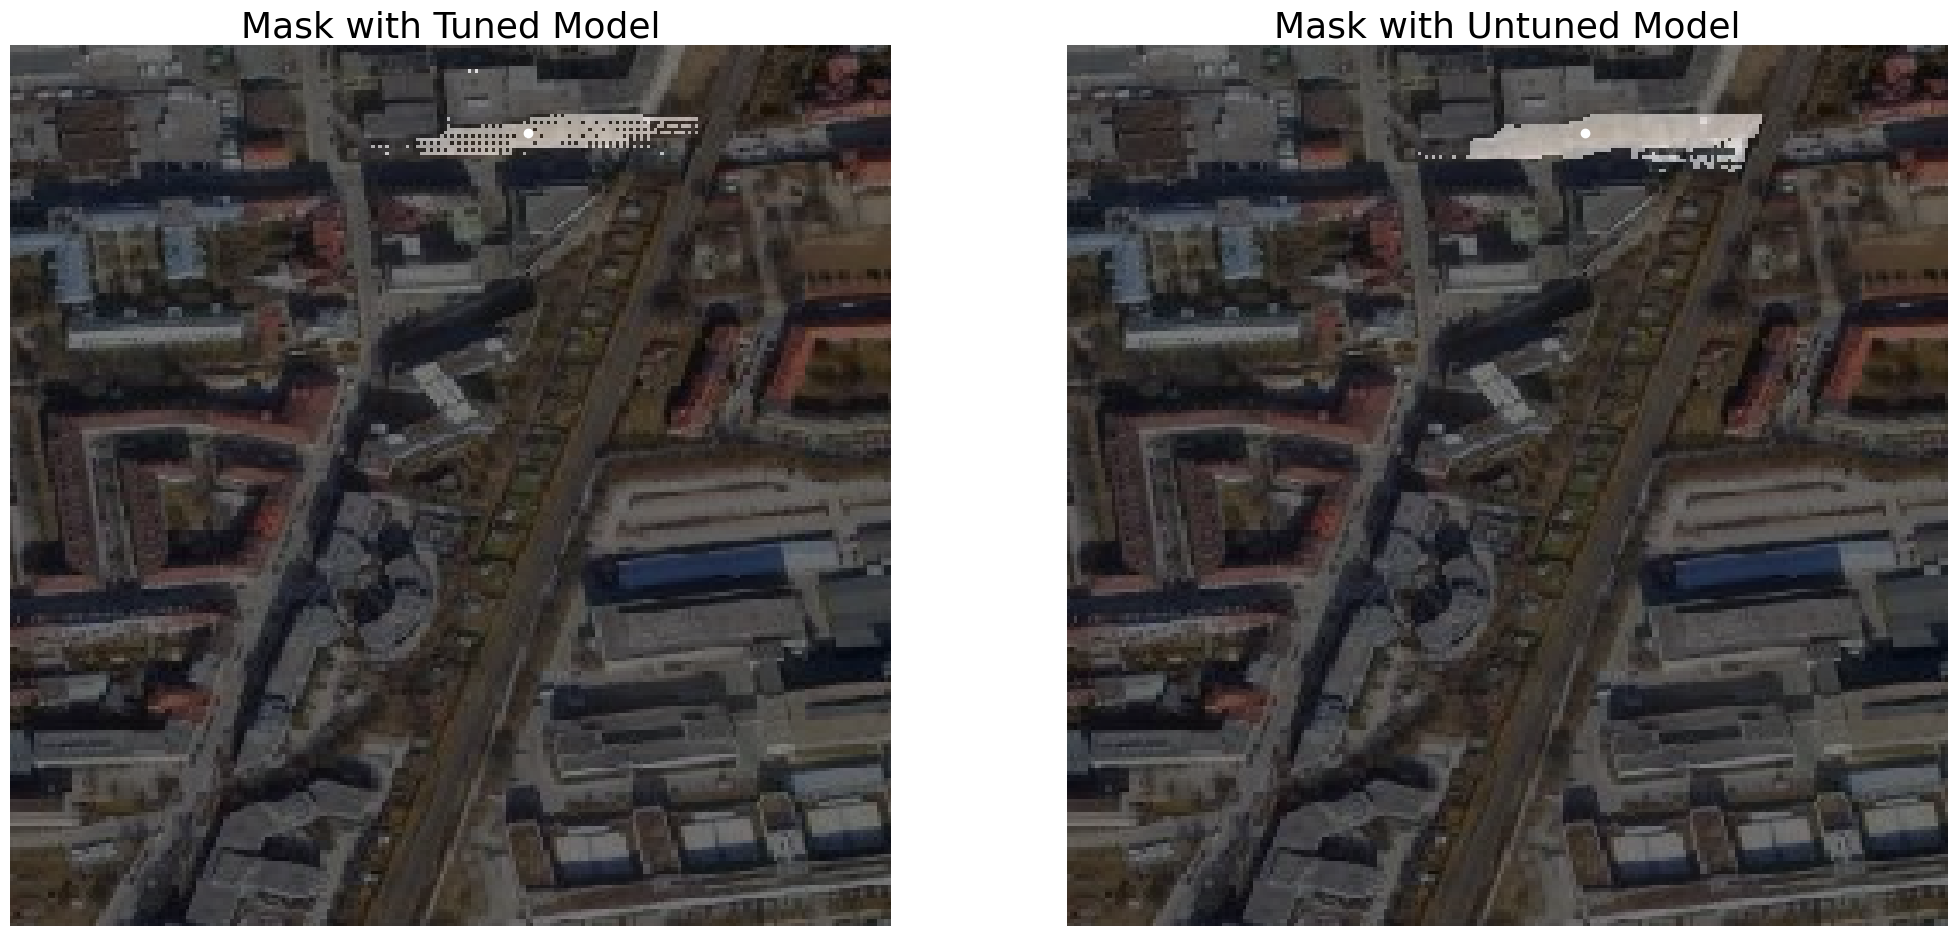

In [19]:
point_x, point_y = 150, 25

input_points = np.array([[point_x, point_y]])
point_labels = np.array([1])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=False,
)

%matplotlib inline 
_, axs = plt.subplots(1, 2, figsize=(25, 25))

axs[0].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned.astype(int)[0,...]*255], axis=-1)).astype(int))
axs[0].plot(point_x, point_y, color='white', marker = 'o')
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')

axs[1].imshow(((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig.astype(int)[0,...]*255], axis=-1)).astype(int)))
axs[1].plot(point_x, point_y, color='white', marker = 'o')
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()  

In [20]:
masks_orig, confidences_orig, _ = predictor_original.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=True
)

masks_tuned, confidences_tuned, _ = predictor_tuned.predict(
    point_coords=input_points,
    point_labels = point_labels,
    box=None,
    multimask_output=True
)

assert len(confidences_tuned) == len(confidences_orig)

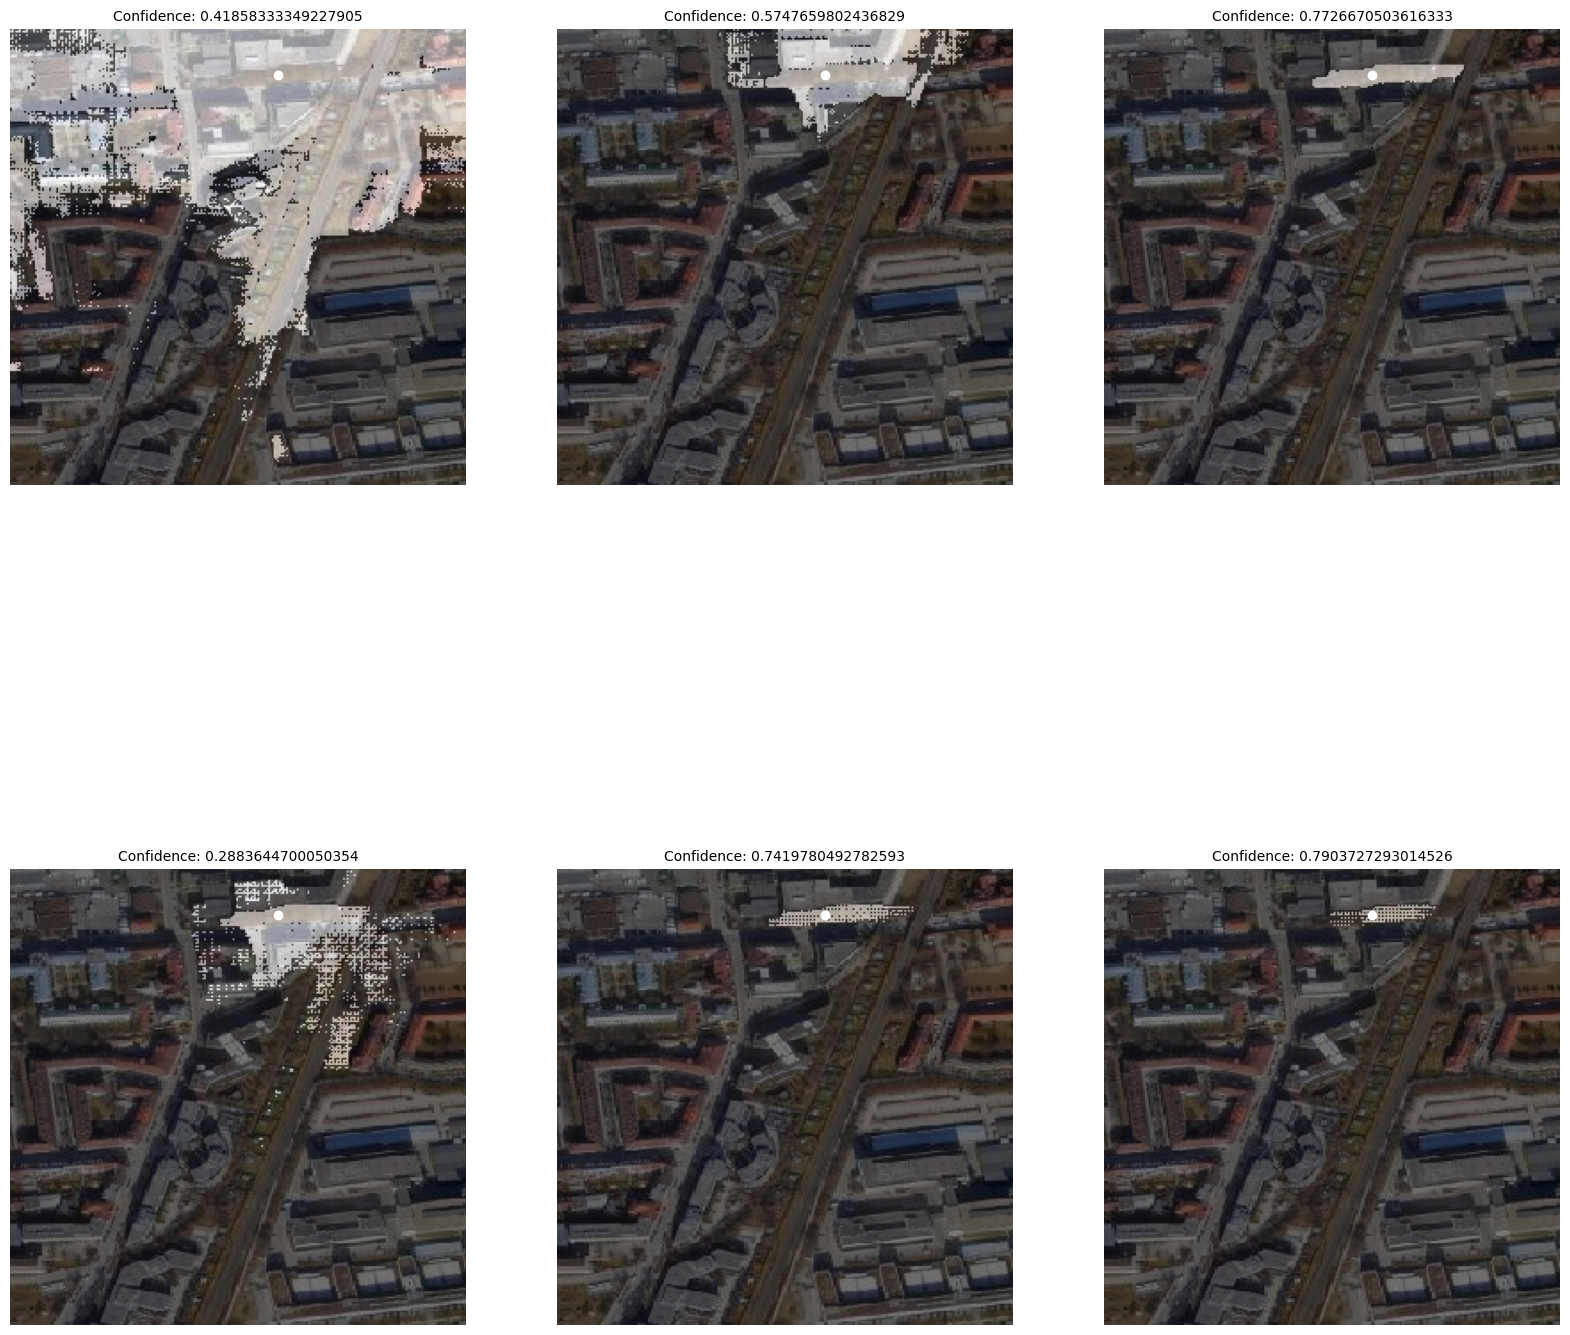

In [21]:
%matplotlib inline 
_, axs = plt.subplots(2, max(len(confidences_orig), len(confidences_tuned)), figsize=(20, 20))

for ax_id in range(len(confidences_orig)):
  axs[0, ax_id].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_orig[ax_id,:,:].astype(int)*255], axis=-1)).astype(int))
  axs[0, ax_id].plot(point_x, point_y, color='white', marker = 'o')
  axs[0, ax_id].set_title(f'Confidence: {confidences_orig[ax_id]}', fontsize=10)
  axs[0, ax_id].axis('off')

for ax_id in range(len(confidences_tuned)):
  axs[1, ax_id].imshow((0.5*test_datapoint['sat'] + 0.5*np.stack(3*[masks_tuned[ax_id,:,:].astype(int)*255], axis=-1)).astype(int))
  axs[1, ax_id].plot(point_x, point_y, color='white', marker = 'o')
  axs[1, ax_id].set_title(f'Confidence: {confidences_tuned[ax_id]}', fontsize=10)
  axs[1, ax_id].axis('off')